In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

/home/pdcnguyen/Desktop/Project_ML/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


alpha_t = 1 - beta_t
alpha_t_hat = a_0 * ... * a_t
x_t = sqrt(alpha_t_hat) * x_0 + sqrt(1-alpha_t_hat) * noise

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

In [3]:
transform_pipelines = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),  # (3,W,H)
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
)


undo_transform_pipelines = transforms.Compose(
    [
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(
            lambda t: (t * 255.0).numpy().astype(np.uint8)
        ),  # Scale data between [0.,255.]
    ]
)

In [ ]:
def load_data(dataset="CIFAR10", Train=True, batch_size=16, transform=None):
    trainset = CIFAR10(root="./data", train=Train, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(
        trainset, shuffle=True, batch_size=batch_size
    )

    trainimages, trainlabels = next(iter(trainloader))
    return trainimages, trainlabels

In [ ]:
def display_images(img, labels, nrow=3):
    fig, axs = plt.subplots(nrow, 3, figsize=(10, 2 * nrow))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for j in range(nrow):
        images_to_display = img[j].permute(1, 2, 0)
        images_to_display = images_to_display / 2 + 0.5  # unnormalize
        noisy_images = noise_scheduler(images_to_display, t, betas)

        for i, image in enumerate(noisy_images):
            axs[j, i].imshow(torch.clamp(image, 0.0, 1.0))
            axs[j, i].axis("off")
    plt.show()

In [68]:
def noise_scheduler(
    x_0: torch.tensor, t: torch.tensor, betas: torch.tensor, device: str
):
    noise = torch.randn(size=x_0.shape)

    alpha_hats = torch.cumprod(1 - betas, axis=0)

    selected_alpha_hats = alpha_hats[t]
    selected_alpha_hats = selected_alpha_hats.reshape(shape=(t.shape[0], 1, 1, 1))

    mean = torch.sqrt(selected_alpha_hats) * x_0
    variance = torch.sqrt(1.0 - selected_alpha_hats) * noise

    x_ts = mean + variance

    return x_ts.to(device), noise.to(device)

In [106]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)
        for i, l in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x[None, :, :, :])[0]
                x += h.pop()
            x = self.act(l(x))

        return x

In [130]:
images, labels = load_data(batch_size=8, transform=transform_pipelines)

Files already downloaded and verified


Finished epoch 0. Average loss for this epoch: 0.751162
Finished epoch 100. Average loss for this epoch: 0.478809
Finished epoch 200. Average loss for this epoch: 0.481479


(0.0, 1.0)

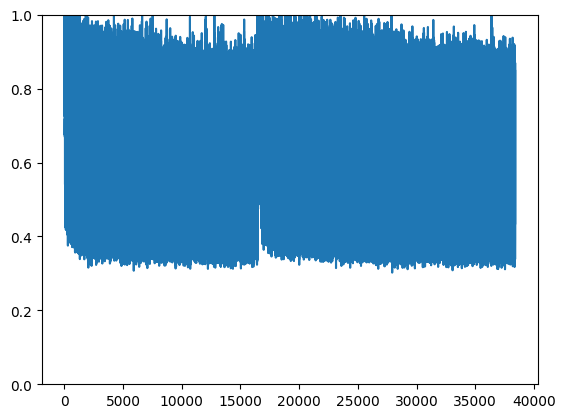

In [133]:
# SINGLE IMAGE TRAINING
img = images[0]
# Dataloader (you can mess with batch size)
BATCH_SIZE = 128

# How many runs through the data should we do?
NO_EPOCHS = 300

# How time steps for scheduler?
TIME_STEPS = 10
BETAS = torch.linspace(0.0001, 0.02, TIME_STEPS)

# Create the network
model = BasicUNet(in_channels=3, out_channels=3)
model.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(NO_EPOCHS):
    img_batch = torch.stack([img] * BATCH_SIZE)
    t = torch.randint(0, TIME_STEPS, (BATCH_SIZE,)).long()

    img_batch_noisy, noise_batch = noise_scheduler(
        x_0=img_batch, t=t, betas=BETAS, device=device
    )

    for img_noisy, noise in zip(img_batch_noisy, noise_batch):
        predicted_noise = model(img_noisy)

        loss = loss_fn(predicted_noise, noise)
        losses.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

    # Print our the average of the loss values for this epoch:
    if epoch % 100 == 0:
        avg_loss = sum(losses[-BATCH_SIZE:]) / BATCH_SIZE
        print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 1)

<Figure size 3000x3000 with 0 Axes>

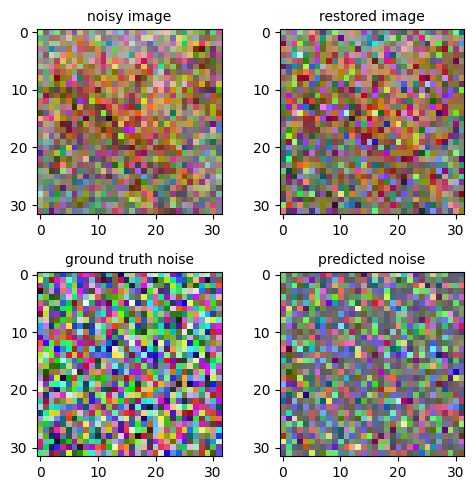

In [135]:
t = torch.randint(0, TIME_STEPS, (1,)).long()
img_noisy, noise = noise_scheduler(x_0=img, t=t, betas=BETAS, device=device)

with torch.no_grad():
    predicted_noise = model(img_noisy[0])

    predicted_noise = predicted_noise.cpu()
    noise = noise.cpu()

    img_n = img_noisy[0].cpu()

    restored_img = img_n - predicted_noise

    plt.figure(figsize=(30, 30))
    f, ax = plt.subplots(2, 2, figsize=(5, 5))

    ax[0, 0].imshow(undo_transform_pipelines(img_n))
    ax[0, 0].set_title(f"noisy image", fontsize=10)
    ax[0, 1].imshow(undo_transform_pipelines(restored_img))
    ax[0, 1].set_title(f"restored image", fontsize=10)

    ax[1, 0].imshow(undo_transform_pipelines(noise))
    ax[1, 0].set_title(f"ground truth noise", fontsize=10)
    ax[1, 1].imshow(undo_transform_pipelines(predicted_noise))
    ax[1, 1].set_title(f"predicted noise", fontsize=10)

    f.tight_layout()
    plt.show()